<p style="font-family: Arial; font-size:3.75vw;color:purple; font-style:bold"><br>
Prueba meli
</p><br>

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold">
Identificación de vendedores relevantes para el negocio </p>


## 1. Recolección de Información

In [99]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import datetime
#from sklearn.datasets import make_blobs
from sklearn import preprocessing
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
import gower
import umap
import plotnine as p9



In [2]:
#categorías de meli en Colombia
cats = requests.get('https://api.mercadolibre.com/sites/MCO/categories')
prueba = cats.json()
df = pd.DataFrame(prueba)
df.head()

,id,name
0,MCO1747,Accesorios para Vehículos
1,MCO441917,Agro
2,MCO1403,Alimentos y Bebidas
3,MCO1071,Animales y Mascotas
4,MCO1367,Antigüedades y Colecciones


In [3]:
# Se trae la información de los primeros 1000 items de cada categoría listada en 'cats'
# MCO1039 camaras y accesorios
# MCO1648 computacion
# MCO1000 Electrónica, Audio y Video

cats = ['MCO1000', 'MCO1039', 'MCO1648']
list_offset = [i*50 for i in range(0,20)]

df_cats = pd.DataFrame()

for cat_id in cats:
    
    df_item = pd.DataFrame()
    for offset in list_offset:
        url = f'https://api.mercadolibre.com/sites/MCO/search?category={cat_id}&offset={offset}'
        request = requests.get(url)
        item = request.json()
        df = pd.DataFrame(item['results'])
        df_item = df_item.append(df)
    df_cats = df_cats.append(df_item)

In [4]:
df_cats.head(2)

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,tags,catalog_listing,use_thumbnail_id,offer_score,offer_share,match_score,winner_item_id,melicoin,order_backend,differential_pricing
0,MCO618049088,MCO,Audífonos Sony Zx Series Mdr-zx110 Negro,"{'id': 168810672, 'permalink': None, 'registra...",39900,"{'id': 'MCO618049088', 'prices': [{'id': '1', ...",None,COP,240,2054,...,"[loyalty_discount_eligible, good_quality_pictu...",True,True,None,None,None,None,None,1,NaN
1,MCO627599757,MCO,Mini Drone Dji Mavic Mini 2 Drdji018 Fly More ...,"{'id': 394887418, 'permalink': None, 'registra...",2819900,"{'id': 'MCO627599757', 'prices': [{'id': '25',...",None,COP,13,493,...,"[good_quality_picture, immediate_payment, cart...",True,True,None,None,None,None,None,2,NaN


In [6]:
#df_item.shape

In [7]:
# lista de vendedores de los primeros mil productos de la categoría
vendedores = pd.DataFrame(df_cats['seller'].tolist())
unicos = pd.DataFrame(vendedores['id'].unique())
len(unicos)

766

In [33]:
df_sellers = pd.DataFrame()

for seller_id in vendedores['id'].unique():
    url = f'https://api.mercadolibre.com/sites/MCO/search?seller_id={seller_id}'
    request = requests.get(url)
    info_seller = request.json()
    
    inf_seller_1 = pd.DataFrame([info_seller['seller']])[['id','nickname','permalink','registration_date',
                                                            'real_estate_agency','car_dealer']]
    inf_seller_2 = pd.DataFrame([info_seller['seller']['seller_reputation']])[['level_id','power_seller_status']]
    inf_seller_3 = pd.DataFrame([info_seller['seller']['seller_reputation']['transactions']])[['canceled','period'
                                                                                           ,'total','completed']]
    inf_seller_4 = pd.DataFrame([info_seller['seller']['seller_reputation']['transactions']['ratings']])
    inf_seller_5 = pd.DataFrame([info_seller['seller']['seller_reputation']['metrics']['sales']])
    inf_seller_5.columns = ['last_period','last_completed']


    seller = pd.concat([inf_seller_1, inf_seller_2, inf_seller_3, inf_seller_4, inf_seller_5], axis=1)
    df_sellers = df_sellers.append(seller)

In [34]:
df_sellers.shape

(766, 17)

In [35]:
df_sellers.head(2)

,id,nickname,permalink,registration_date,real_estate_agency,car_dealer,level_id,power_seller_status,canceled,period,total,completed,negative,neutral,positive,last_period,last_completed
0,168810672,SONY COLOMBIA,http://perfil.mercadolibre.com.co/SONY+COLOMBIA,2014-10-14T12:03:55.000-04:00,False,False,5_green,platinum,1096,historic,22683,21587,0.02,0.02,0.96,60 days,3280
0,394887418,TIENDASOFICIALESCOL,http://perfil.mercadolibre.com.co/TIENDASOFICI...,2019-01-14T13:12:49.000-04:00,False,False,5_green,platinum,1679,historic,22216,20537,0.09,0.04,0.87,60 days,2652


In [11]:
#otra informacion que podria ser util

#paging = pd.DataFrame([info_seller['paging']])
#results = pd.DataFrame(info_seller['results'])
#sort = pd.DataFrame([info_seller['sort']])
#available_sorts = pd.DataFrame(info_seller['available_sorts'])
#filters = pd.DataFrame(info_seller['filters'])
#available_filters = pd.DataFrame(info_seller['available_filters'])

## 2. Exploración y limpieza de la Información

In [36]:
df_sellers.head(2)

,id,nickname,permalink,registration_date,real_estate_agency,car_dealer,level_id,power_seller_status,canceled,period,total,completed,negative,neutral,positive,last_period,last_completed
0,168810672,SONY COLOMBIA,http://perfil.mercadolibre.com.co/SONY+COLOMBIA,2014-10-14T12:03:55.000-04:00,False,False,5_green,platinum,1096,historic,22683,21587,0.02,0.02,0.96,60 days,3280
0,394887418,TIENDASOFICIALESCOL,http://perfil.mercadolibre.com.co/TIENDASOFICI...,2019-01-14T13:12:49.000-04:00,False,False,5_green,platinum,1679,historic,22216,20537,0.09,0.04,0.87,60 days,2652


In [266]:
#df_sellers.isna().sum()

In [37]:
#eliminamos las variables con valor constante
df_sellers = df_sellers.loc[:,df_sellers.apply(pd.Series.nunique) != 1]
df_sellers.head(2)

,id,nickname,permalink,registration_date,level_id,power_seller_status,canceled,total,completed,negative,neutral,positive,last_period,last_completed
0,168810672,SONY COLOMBIA,http://perfil.mercadolibre.com.co/SONY+COLOMBIA,2014-10-14T12:03:55.000-04:00,5_green,platinum,1096,22683,21587,0.02,0.02,0.96,60 days,3280
0,394887418,TIENDASOFICIALESCOL,http://perfil.mercadolibre.com.co/TIENDASOFICI...,2019-01-14T13:12:49.000-04:00,5_green,platinum,1679,22216,20537,0.09,0.04,0.87,60 days,2652


In [38]:
df_sellers.shape

(766, 14)

In [39]:
dict_level = {None:0, '1_red':1, '2_orange':2, '3_yellow':3,
              '4_light_green': 4, '5_green':5}
dict_powerss = {None:0, 'silver': 1, 'platinum': 2, 'gold': 3} 
dict_period = {'365 days': 1, '60 days': 5} 

In [40]:
df_sellers = df_sellers.replace({"level_id": dict_level})
df_sellers = df_sellers.replace({"power_seller_status": dict_powerss})
df_sellers = df_sellers.replace({"last_period": dict_period})
df_sellers.head(2)

,id,nickname,permalink,registration_date,level_id,power_seller_status,canceled,total,completed,negative,neutral,positive,last_period,last_completed
0,168810672,SONY COLOMBIA,http://perfil.mercadolibre.com.co/SONY+COLOMBIA,2014-10-14T12:03:55.000-04:00,5,2,1096,22683,21587,0.02,0.02,0.96,5,3280
0,394887418,TIENDASOFICIALESCOL,http://perfil.mercadolibre.com.co/TIENDASOFICI...,2019-01-14T13:12:49.000-04:00,5,2,1679,22216,20537,0.09,0.04,0.87,5,2652


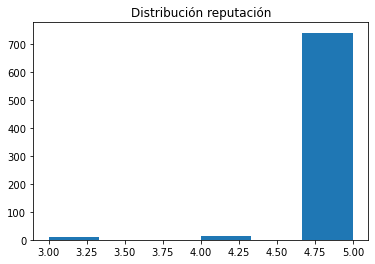

In [41]:
#distribucion variable reputación de los vendedores
level_hist = df_sellers["level_id"]
(n, bins, patches) = plt.hist(level_hist, bins=6, label='hist')
plt.title("Distribución reputación")
plt.show()

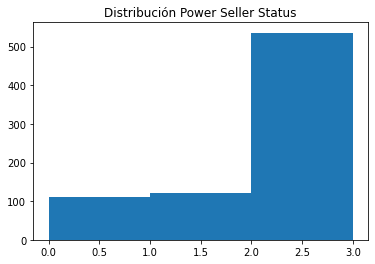

In [42]:
#distribucion variable reputación de los vendedores
powerstatus_hist = df_sellers["power_seller_status"]
(n, bins, patches) = plt.hist(powerstatus_hist, bins=3, label='hist')
plt.title("Distribución Power Seller Status")
plt.show()

## 3. Agrupación y creación de variables

In [43]:
df_sellers['porc_vendidos'] = df_sellers['completed']/df_sellers['total']
df_sellers['prop_last_completed'] = df_sellers['last_period']*df_sellers['last_completed']
df_sellers['good_comments'] = df_sellers["neutral"] + df_sellers["positive"]


today = datetime.date.today()
df_sellers["registration_date"] = pd.to_datetime(df_sellers["registration_date"]).dt.date
df_sellers["antiguedad_meses"] = ((abs(pd.to_datetime(today) - pd.to_datetime(df_sellers["registration_date"])).dt.days)/30) // 1


df_sellers = df_sellers.drop(columns = ["completed", "total","canceled", "negative", "last_period",
                                    "last_completed", "neutral", "positive"])

df_sellers.head(5)

,id,nickname,permalink,registration_date,level_id,power_seller_status,porc_vendidos,prop_last_completed,good_comments,antiguedad_meses
0,168810672,SONY COLOMBIA,http://perfil.mercadolibre.com.co/SONY+COLOMBIA,2014-10-14,5,2,0.951682,16400,0.98,90.0
0,394887418,TIENDASOFICIALESCOL,http://perfil.mercadolibre.com.co/TIENDASOFICI...,2019-01-14,5,2,0.924424,13260,0.91,38.0
0,91896930,COMERTEC.CO,http://perfil.mercadolibre.com.co/COMERTEC.CO,2006-02-23,5,2,0.943277,43230,0.96,195.0
0,323005693,STREETGAMINGSTORE,http://perfil.mercadolibre.com.co/STREETGAMING...,2018-05-21,5,2,0.964770,1565,1.00,46.0
0,326375003,NBNORTHBAYOU COLOMBIASAS,http://perfil.mercadolibre.com.co/NBNORTHBAYOU...,2018-06-06,5,2,0.972525,11380,0.99,45.0


In [53]:
df = df_sellers.iloc[:,4:]
df.head(5)

,level_id,power_seller_status,porc_vendidos,prop_last_completed,good_comments,antiguedad_meses
0,5,2,0.951682,16400,0.98,90.0
0,5,2,0.924424,13260,0.91,38.0
0,5,2,0.943277,43230,0.96,195.0
0,5,2,0.964770,1565,1.00,46.0
0,5,2,0.972525,11380,0.99,45.0


In [54]:
df.shape

(766, 6)

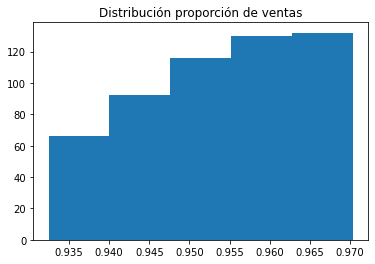

In [75]:
#creacion target value

#distribucion de las ventas de los vendedores seleccionados
ventas = df["porc_vendidos"]
ventas = ventas[ventas.between(ventas.quantile(.15), ventas.quantile(.85))]
(n, bins, patches) = plt.hist(ventas, bins=5, label='hist')
plt.title("Distribución proporción de ventas")
plt.show()

In [595]:
bins = bins.tolist()
bins[0] = bins[0]-0.01
bins

[0.9247826086956522,
 0.9418954300222152,
 0.9490082513487782,
 0.9561210726753412,
 0.9632338940019042,
 0.9703467153284672]

In [596]:
bins[5]

0.9703467153284672

In [101]:
#seleccionamos los vendedores con porcentajes de venta entre los cuantiles seleccionados
min_ventas = df["porc_vendidos"].quantile(.15)
max_ventas = df["porc_vendidos"].quantile(.85)
df_train = df[df["porc_vendidos"].between(min_ventas, max_ventas)]
df_train.shape

(536, 6)

In [598]:
#labels = list(range(1, 6))
#df_train.loc[:,'binned'] = pd.cut(df_train['porc_vendidos'], bins=bins, labels=labels)
#del df_train["porc_vendidos"]
#df_train.head() 

In [78]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,level_id,power_seller_status,porc_vendidos,prop_last_completed,good_comments,antiguedad_meses
level_id,1.000000,0.316679,0.227769,0.089665,0.104105,0.072204
power_seller_status,0.316679,1.000000,0.238201,0.159477,0.025672,0.066478
porc_vendidos,0.227769,0.238201,1.000000,0.126939,0.281904,0.073636
prop_last_completed,0.089665,0.159477,0.126939,1.000000,-0.057683,0.077479
good_comments,0.104105,0.025672,0.281904,-0.057683,1.000000,0.195762
antiguedad_meses,0.072204,0.066478,0.073636,0.077479,0.195762,1.000000


## 4. K-Medoids

Se elige este método ya que es una variación de K-means que tiene en cuenta el uso de variables categóricas y continuas, haciendo uso de una métrica no euclideana.

Para la aplicación de este método se tomó como guía los ejemplos presentados en 
https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b

In [102]:
def evaluate_clusters(scores,  preds, labels, name='', X=None):

  if X is not None:

    silhouette = silhouette_score(X, preds, metric='euclidean')
    cal_har = calinski_harabasz_score(X, preds)
    dav_bould = davies_bouldin_score(X, preds)

    adj_mut_info = adjusted_mutual_info_score(labels, preds, average_method='arithmetic')
    adj_rand = adjusted_rand_score(labels, preds)

    content = {'Algorithm':name,
               'Silhouette':silhouette,
               'Calinski_Harabasz':cal_har,
               'Davis Bouldin':dav_bould,
               'Adjusted_Mutual_Info':adj_mut_info,
               'Adjusted_Rand_Score':adj_rand}

    scores = scores.append(content, ignore_index = True)

  else:

    adj_mut_info = adjusted_mutual_info_score(labels, preds, average_method='arithmetic')
    adj_rand = adjusted_rand_score(labels, preds)

    content = {'Algorithm':name,
               'Silhouette':np.NaN,
               'Calinski_Harabasz':np.NaN,
               'Davis Bouldin':np.NaN,
               'Adjusted_Mutual_Info':adj_mut_info,
               'Adjusted_Rand_Score':adj_rand}

    scores = scores.append(content, ignore_index = True)


  return scores

In [103]:
df_train.head(2)

,level_id,power_seller_status,porc_vendidos,prop_last_completed,good_comments,antiguedad_meses
0,5,2,0.951682,16400,0.98,90.0
0,5,2,0.943277,43230,0.96,195.0


In [104]:
df_train.shape

(536, 6)

In [63]:
!pip install gower

In [105]:
num_clusters = 4
random_state = 32


gower_data = df_train.copy()
dist_matrix = gower.gower_matrix(gower_data)

# create target variable
target = df_train.pop('power_seller_status')
labels = preprocessing.LabelEncoder().fit_transform(target)

df_train.head()

,level_id,porc_vendidos,prop_last_completed,good_comments,antiguedad_meses
0,5,0.951682,16400,0.98,90.0
0,5,0.943277,43230,0.96,195.0
0,5,0.964770,1565,1.00,46.0
0,5,0.969679,3770,0.99,59.0
0,5,0.944206,2740,0.96,19.0


In [106]:
scores = pd.DataFrame()
predictions = pd.DataFrame()
predictions['Label'] = labels

In [107]:
umap_embeddings = umap.UMAP(random_state=42, n_components=2).fit_transform(dist_matrix)


In [108]:
gower_data['x'] = umap_embeddings[:,0]
gower_data['y'] = umap_embeddings[:,1]

gower_data['target'] = [str(x) for x in labels]


In [109]:
gower_clusterer = KMedoids(n_clusters=num_clusters, metric='precomputed',
                           method='pam', init='build', 
                           max_iter=300, random_state=random_state).fit(dist_matrix)

In [110]:
gower_data["preds"] = gower_clusterer.labels_
gower_data["preds"] = gower_data["preds"].apply(str)

predictions['gower_preds'] = gower_clusterer.labels_


In [111]:
scores = evaluate_clusters(scores,  gower_data["preds"].values,
                           gower_data['target'].values, 
                           name='gower_matrix_kmediods_pam', 
                           X=dist_matrix)
scores

,Adjusted_Mutual_Info,Adjusted_Rand_Score,Algorithm,Calinski_Harabasz,Davis Bouldin,Silhouette
0,0.240818,0.126281,gower_matrix_kmediods_pam,130.169872,1.560897,0.19924


In [112]:
#--------------------------------------------------------------
#-------------------------plots--------------------------------
#--------------------------------------------------------------

p1 = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='target', color='target'))
      + p9.geom_point(alpha=0.6, size=2)
      + p9.ggtitle('Sellers data Gower Matrix UMAP 2D Ground Truth')
      + p9.theme_bw())

p2 = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.6, size=2)
      + p9.ggtitle('Seller data Gower Matrix UMAP 2D KMedoids')
      + p9.theme_bw())


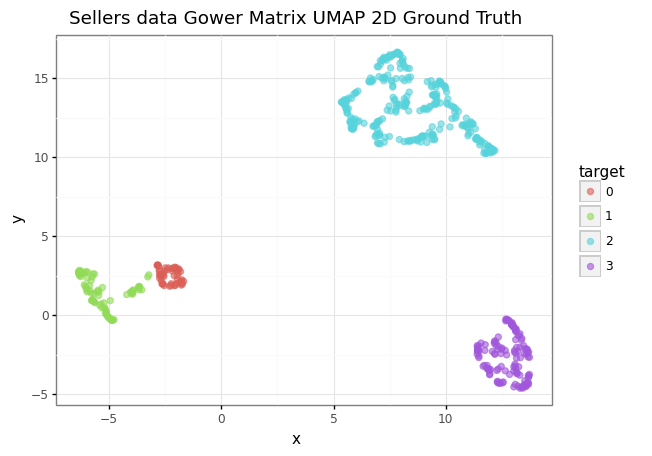

<ggplot: (8784543957294)>

In [113]:
p1

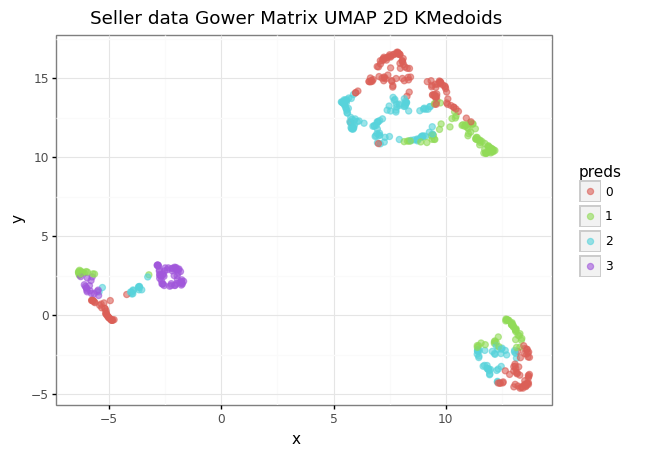

<ggplot: (8784543948605)>

In [114]:
p2


**Pasos a seguir para obtener un modelo mucho más robusto :**
* Obtención óptima de una muestra de datos con más registros y variables bien distribuidas.
* Obtención de nuevas variables y creación de variables a partir de la información de los productos de cada vendedor. Ej: número de productos en el catálogo. Otras variables interesantes a integrar en el modelo son las relacionadas a la calidad de las imágenes de los productos y sus descripciones.
* Ejecución de otros métodos de closterización de información con variables mixtas y comparación de resultados. Ej: K-Prototype.
